# Chapter 4 - Codeblocks

In [1]:
library(rethinking)
data(Howell1)
d <- Howell1

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 2.13)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




For the purpose of the linear model, we restrict data on adults only:

In [2]:
d2 <- d[d$age >= 18, ]

## Grid Approximation

#### Summary functions
Available summary functions `str()`, `summary()` and `precis()` report on the data in different ways. Here's a short comparison:

In [3]:
str(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...


In [4]:
summary(d)

     height           weight            age             male       
 Min.   : 53.98   Min.   : 4.252   Min.   : 0.00   Min.   :0.0000  
 1st Qu.:125.09   1st Qu.:22.008   1st Qu.:12.00   1st Qu.:0.0000  
 Median :148.59   Median :40.058   Median :27.00   Median :0.0000  
 Mean   :138.26   Mean   :35.611   Mean   :29.34   Mean   :0.4724  
 3rd Qu.:157.48   3rd Qu.:47.209   3rd Qu.:43.00   3rd Qu.:1.0000  
 Max.   :179.07   Max.   :62.993   Max.   :88.00   Max.   :1.0000  

In [5]:
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
height,138.2635963,27.6024476,81.108550,165.73500,▁▁▁▁▁▁▁▂▁▇▇▅▁
weight,35.6106176,14.7191782,9.360721,54.50289,▁▂▃▂▂▂▂▅▇▇▃▂▁
age,29.3443934,20.7468882,1.000000,66.13500,▇▅▅▃▅▂▂▁▁
male,0.4724265,0.4996986,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇


#### Choosing Priors

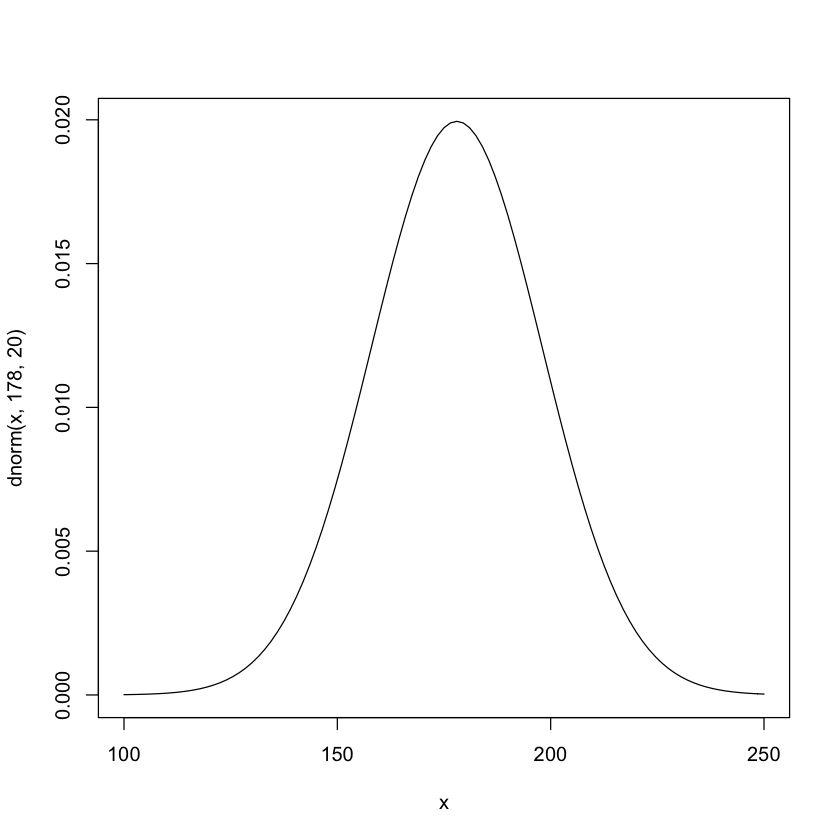

In [6]:
curve(dnorm(x, 178, 20), from=100, to=250)

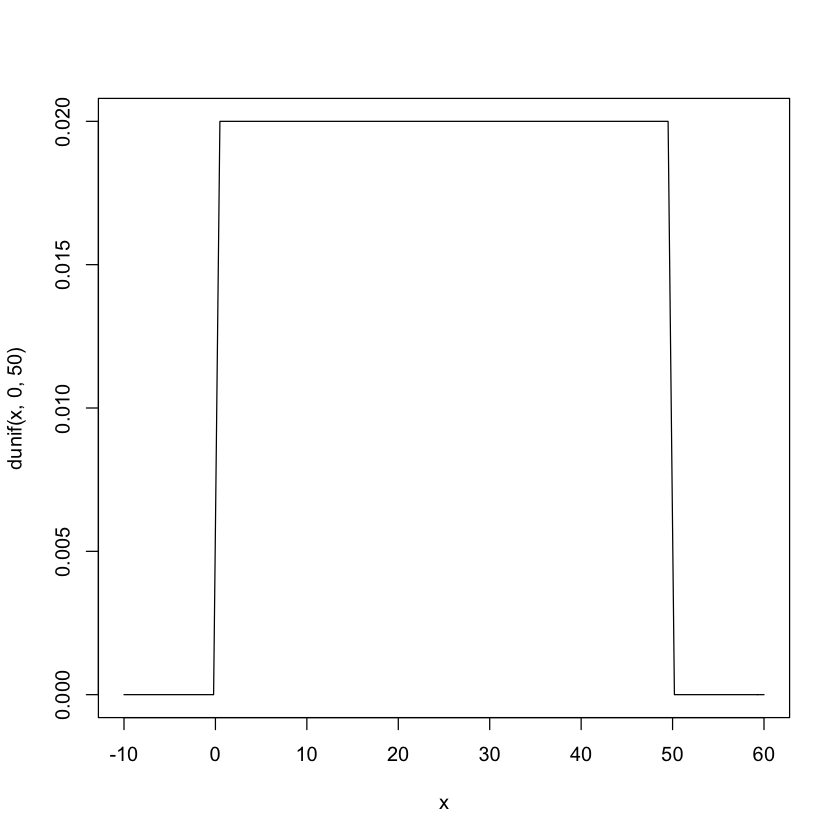

In [7]:
curve(dunif(x, 0, 50), from =-10, to=60)

In [8]:
sample_mu <- rnorm(1e4, 178, 20)
sample_sigma <- runif(1e4, 0, 50)

#### Combining mu and sigma to a prior for body height

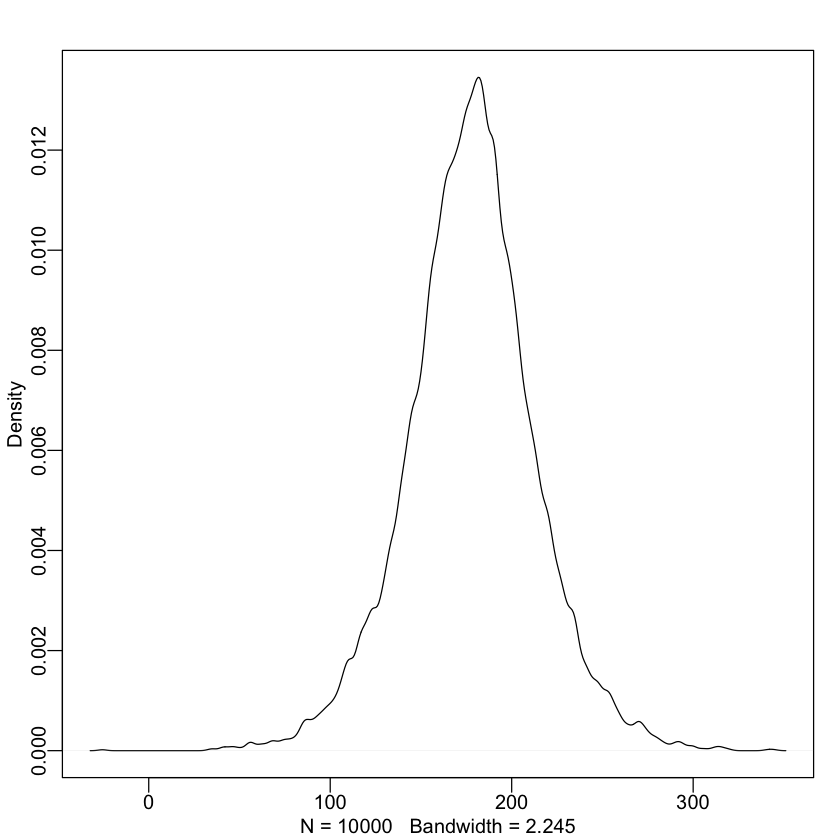

In [9]:
prior_h <- rnorm(1e4, sample_mu, sample_sigma)
dens(prior_h)

##### What happens to the prior of body height when its mean is distributed normally with a large sigma?

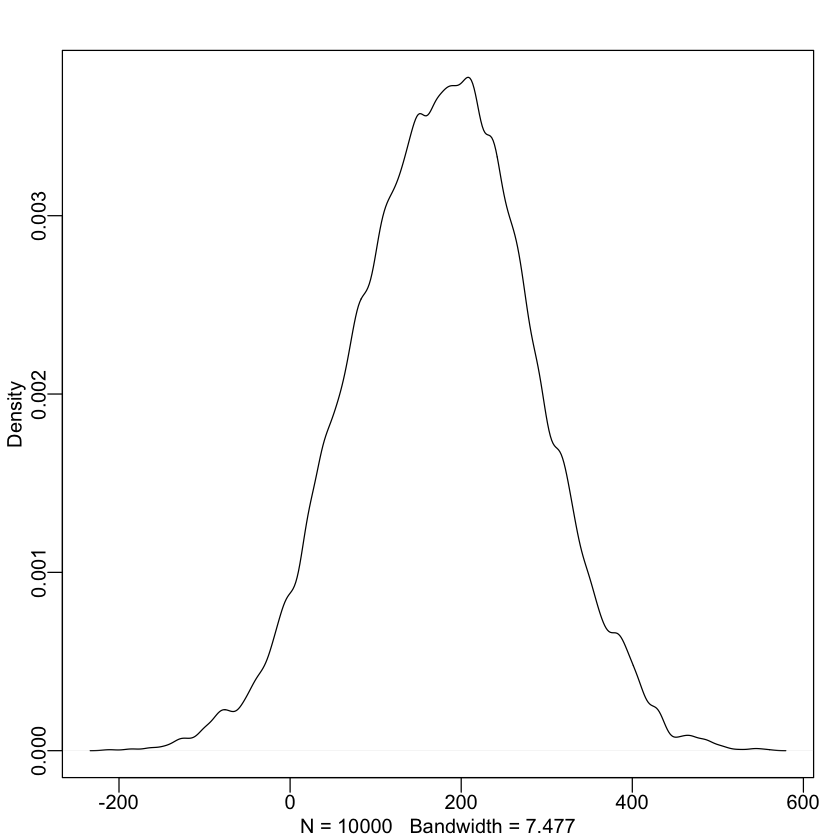

In [10]:
sample_mu_2 <- rnorm(1e4, 178, 100)
prior_h <- rnorm(1e4, sample_mu_2, sample_sigma)
dens(prior_h)

### Grid approximation of the posterior
**target:** find the plausibility (probability) for all the combinations of mu and sigma  
**approach:** approximate the shape of the posterior probability distribution with grid approximation. For each point of the grid, compute 

##### 1. create grid

In [116]:
mu.list <- seq(from=150,to=160,length.out=1000)
sigma.list <- seq(from=7,to=9,length.out=100)

In [117]:
post <-expand.grid(mu=mu.list,sigma=sigma.list)

##### 2. compute probability of the data 
Probability of the data is computed as sum of log(p) at each gridpoint.

In [118]:
post$LL <-sapply(1:nrow(post),function(i)sum(dnorm(
  d2$height,
  post$mu[i],
  post$sigma[i],
  log=TRUE)))

This does three things:
1. **Compute the likelihood of the data:** For each height in the heights data, it computes the probability of this exact height being 'tossed' at each gridpoint - each combination of mu and sigma. 
2. **Summing up the log-probabilities at each gridpoint:** This provides the likelihood of the data at each gridpoint - the likelihood of the data being produced with the gridpoint's parameters mu and sigma.

In [119]:
head(post)

,mu,sigma,LL
,<dbl>,<dbl>,<dbl>
1,150.0000,7,-1299.030
2,150.0100,7,-1298.700
3,150.0200,7,-1298.371
4,150.0300,7,-1298.042
5,150.0400,7,-1297.714
6,150.0501,7,-1297.386


In [120]:
post$LL_s <- exp(post$LL-max(post$LL))

##### 3. add priors

In [121]:
post$prod <- post$LL + dnorm(post$mu,178,20,TRUE) + dunif( post$sigma,0,50,TRUE)

##### 4. normalize to probabilities

In [122]:
post$prob <-exp(post$prod-max(post$prod))

In [123]:
#contour_xyz(post$mu, post$sigma, post$prob)

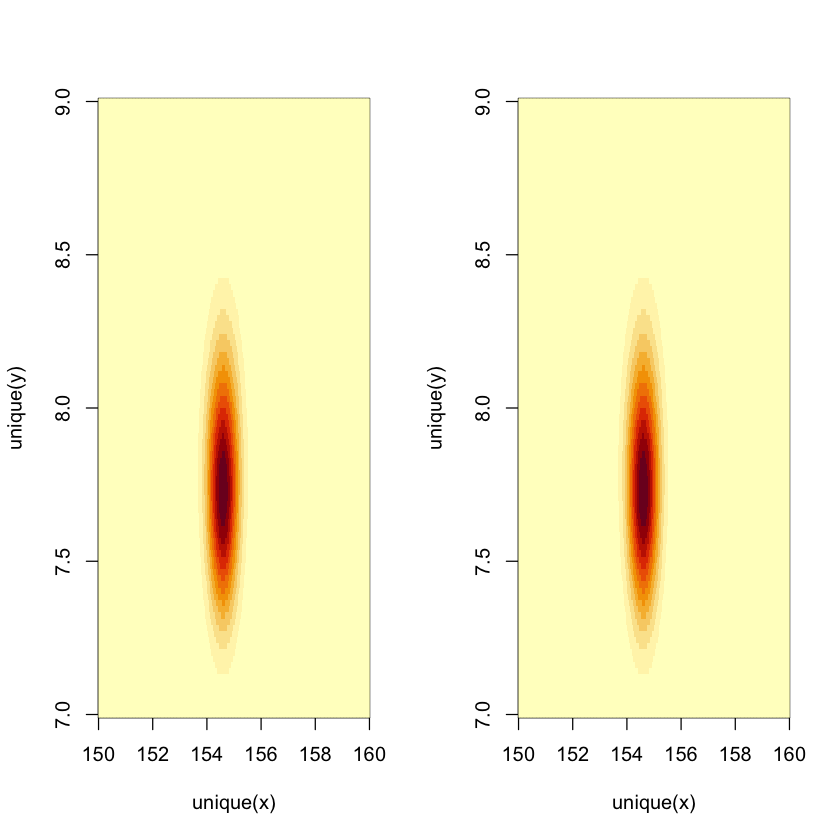

In [124]:
par(mfrow=c(1,2))
image_xyz(post$mu, post$sigma, post$LL_s)
image_xyz(post$mu, post$sigma, post$prob)

The result is an approximate probability distribution for the combinations of mu and sigma on the grid. Apparently, there is not much of a difference before and after adding the prior to the likelihood of the data. 

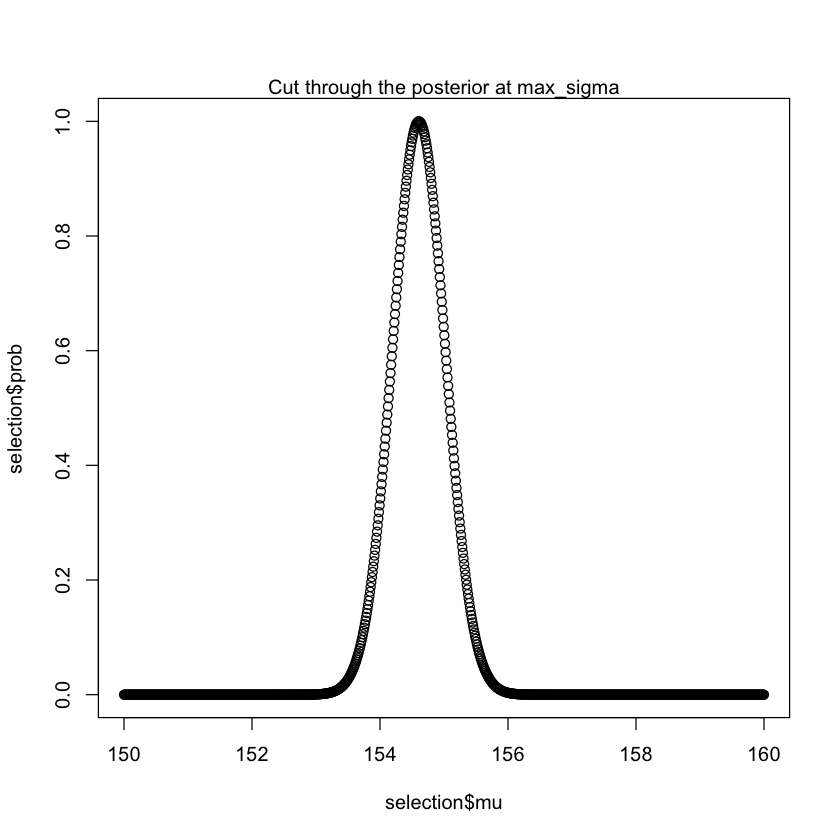

In [137]:
max_prob <- max(post$prob)
max_sigma <- post[post$prob == max_prob, ]$sigma
selection <- post[post$sigma == max_sigma ,]
plot(selection$prob~selection$mu)
mtext('Cut through the posterior at max_sigma')

what do these probabilities mean?

### sampling from the posterior

In [126]:
sample.rows <-sample(1:nrow(post),size=1e4,replace=TRUE,prob=post$prob)
sample.mu <-post$mu[sample.rows]
sample.sigma <-post$sigma[sample.rows]

In [127]:
precis(post)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mu,1.550000e+02,2.8896540,1.505500e+02,159.4500000,▇▇▇▇▇▇▇▇▇▇
sigma,8.000000e+00,0.5831558,7.101010e+00,8.8989899,▇▇▇▇▇▇▇▇▇▇
LL,-1.245318e+03,22.2847481,-1.287560e+03,-1220.8711581,▁▁▁▁▁▂▂▂▂▃▇▁
LL_s,3.746206e-02,0.1315750,2.516481e-30,0.2308582,▇▁▁▁▁▁▁▁▁▁
prod,-1.253816e+03,22.2455609,-1.295912e+03,-1229.3826251,▁▁▁▁▁▂▂▂▃▃▇▂
prob,3.745410e-02,0.1315622,2.950561e-30,0.2307556,▇▁▁▁▁▁▁▁▁▁


In [128]:
str(post)

'data.frame':	100000 obs. of  6 variables:
 $ mu   : num  150 150 150 150 150 ...
 $ sigma: num  7 7 7 7 7 7 7 7 7 7 ...
 $ LL   : num  -1299 -1299 -1298 -1298 -1298 ...
 $ LL_s : num  2.63e-35 3.65e-35 5.08e-35 7.06e-35 9.80e-35 ...
 $ prod : num  -1308 -1308 -1307 -1307 -1307 ...
 $ prob : num  1.95e-35 2.72e-35 3.78e-35 5.26e-35 7.31e-35 ...
 - attr(*, "out.attrs")=List of 2
  ..$ dim     : Named int [1:2] 1000 100
  .. ..- attr(*, "names")= chr [1:2] "mu" "sigma"
  ..$ dimnames:List of 2
  .. ..$ mu   : chr [1:1000] "mu=150.0000" "mu=150.0100" "mu=150.0200" "mu=150.0300" ...
  .. ..$ sigma: chr [1:100] "sigma=7.000000" "sigma=7.020202" "sigma=7.040404" "sigma=7.060606" ...


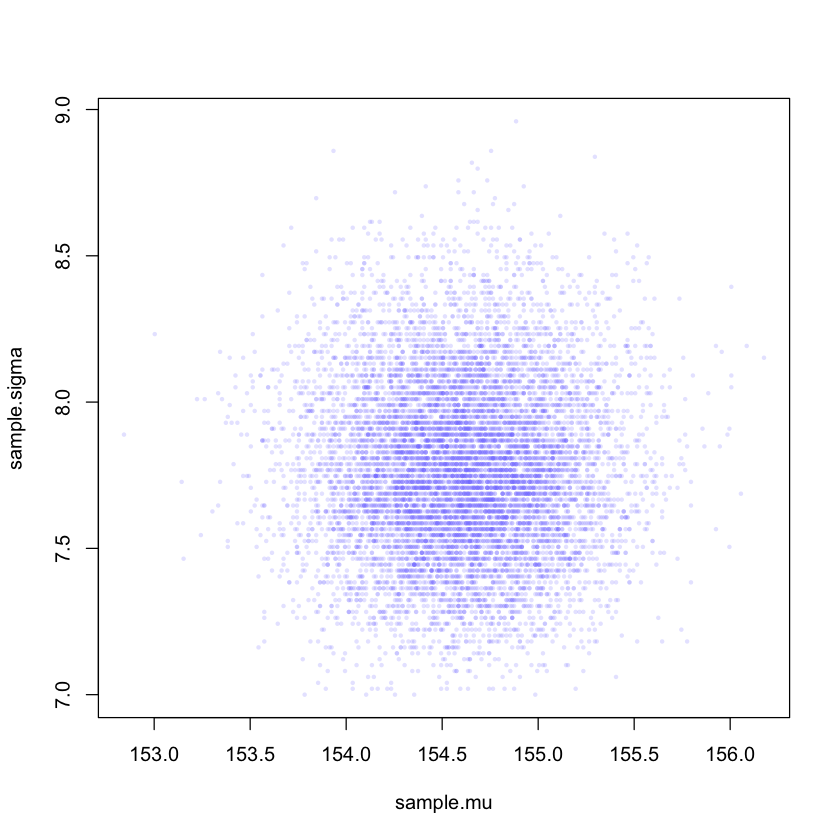

In [135]:
plot(sample.mu,sample.sigma,cex=0.5,pch=16,col=col.alpha(rangi2,0.2))

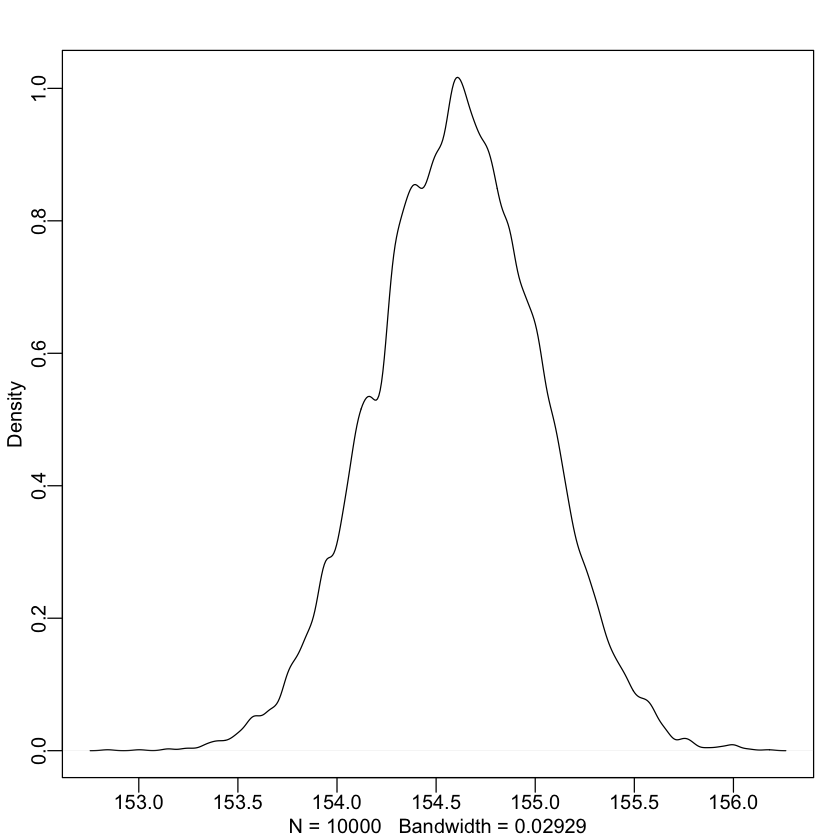

In [130]:
dens(sample.mu)

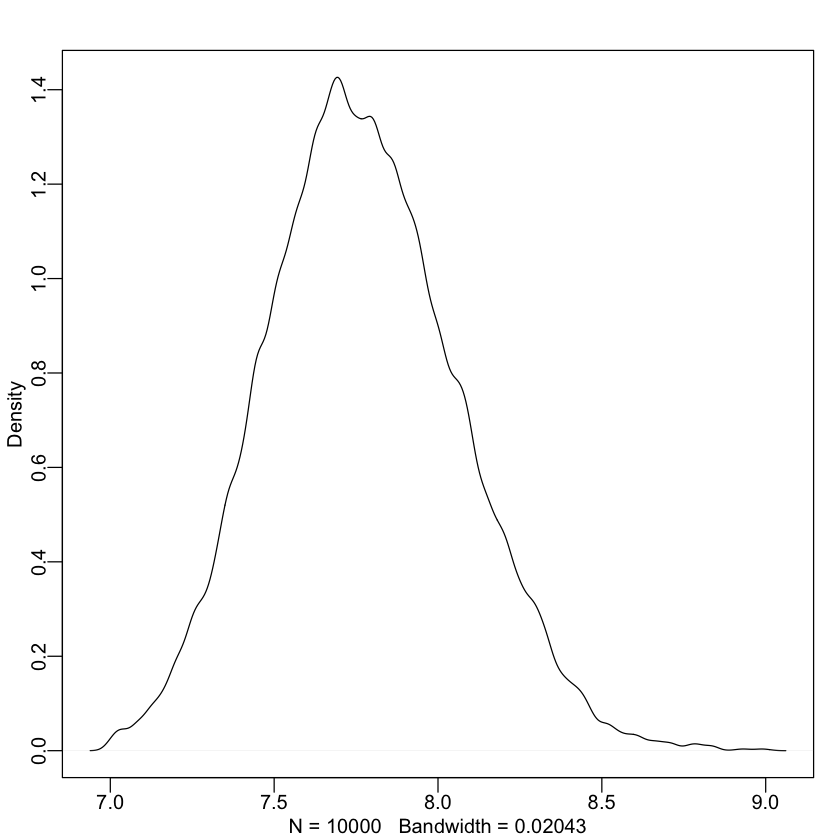

In [108]:
dens(sample.sigma)

#### plausibility intervals

In [109]:
round(PI(sample.mu), 2)

5%    94% 
153.94 155.25

In [110]:
round(PI(sample.sigma), 2)

5%  94% 
7.32 8.25

#### long tail to high variances

In [111]:
d3 <- sample(d2$height, size=20)
mu.list <-seq(from=150,to=170,length.out=200)
sigma.list <-seq(from=4,to=20,length.out=200)
post2 <-expand.grid(mu=mu.list,sigma=sigma.list)

In [112]:
post2$LL <-sapply(1:nrow(post2), function(i) sum(
  dnorm(
    d3, 
    mean=post2$mu[i], 
    sd=post2$sigma[i], 
    log=TRUE )
  ))
post2$prod <-post2$LL + dnorm(post2$mu,178,20,TRUE) + dunif( post2$sigma,0,50,TRUE)
post2$prob <-exp(post2$prod - max(post2$prod))

In [113]:
sample2.rows <-sample(
  1:nrow(post2),
  size=1e4,
  replace=TRUE, 
  prob=post2$prob )
sample2.mu <-post2$mu[sample2.rows]
sample2.sigma <-post2$sigma[sample2.rows]

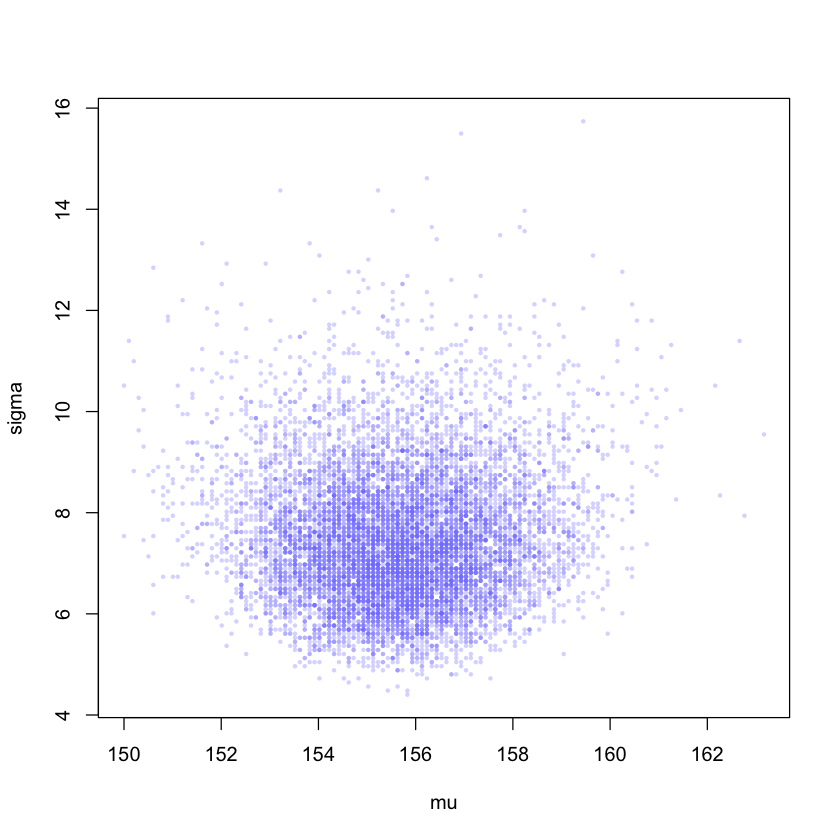

In [114]:
plot( sample2.mu,sample2.sigma,cex=0.5,
      col=col.alpha(rangi2,0.3) ,
      xlab="mu" ,ylab="sigma",pch=16)

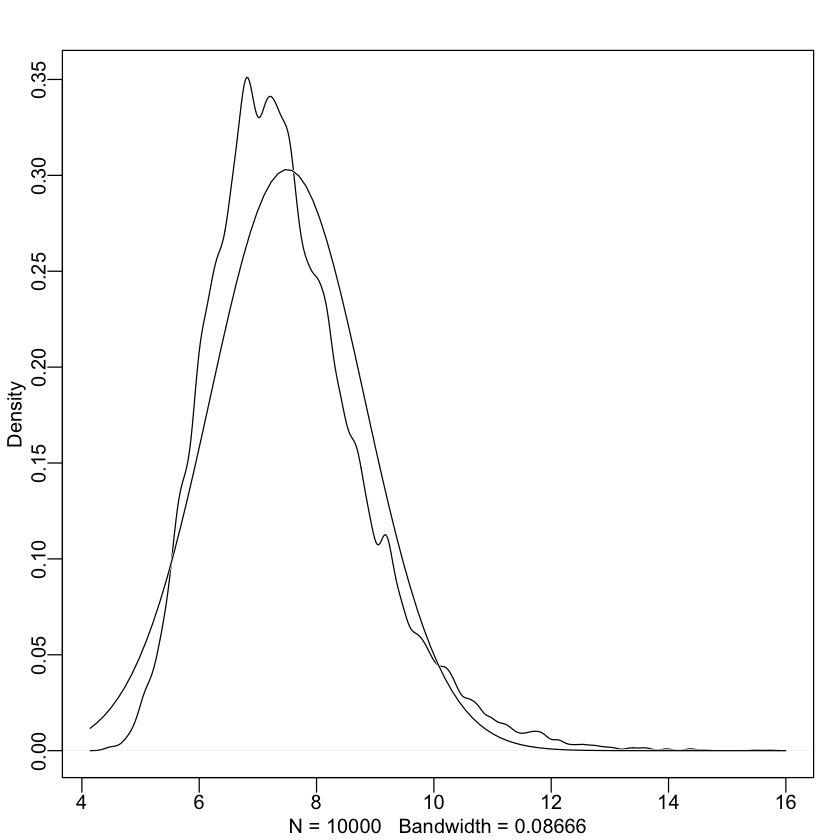

In [115]:
dens( sample2.sigma,norm.comp=TRUE)

## Quadratic Approximation

quadratic approximation of the posterior: again we estimate the posterior based on the data and our prior beliefs. quap very well approximates the shape of the distribution near the maximum

In [116]:
d <-Howell1
d2 <-d[d$age>=18,]

In [117]:
flist <-alist(
  height ~ dnorm(mu,sigma),
  mu ~ dnorm(178,20),
  sigma ~ dunif(0,50)
)

In [118]:
m4.1 <- quap(flist, data=d2)

### changed prior

In [119]:
m4.2 <-quap(
  alist(
    height ~dnorm(mu,sigma),
    mu ~dnorm(178,0.1),
    sigma ~dunif(0,50)
  ) ,data=d2)

In [120]:
precis(m4.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,177.86375,0.1002354,177.70356,178.02395
sigma,24.51756,0.9289235,23.03297,26.00216


In [121]:
vcov(m4.1)

,mu,sigma
mu,0.1697370226,0.0002172446
sigma,0.0002172446,0.0849025889


In [122]:
diag( vcov(m4.1))

mu      sigma 
0.16973702 0.08490259

In [123]:
cov2cor(vcov(m4.1))

,mu,sigma
mu,1.000000000,0.001809673
sigma,0.001809673,1.000000000


### sampling the posterior

In [124]:
post <-extract.samples(m4.1,n=1e4)

In [125]:
head(post)

,mu,sigma
,<dbl>,<dbl>
1,154.7169,7.509898
2,154.1564,7.578187
3,154.4952,6.905406
4,154.4333,7.846685
5,153.8477,7.409199
6,154.3423,7.165081


In [126]:
precis(post)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
mu,154.603331,0.4147254,153.929138,155.252551,▁▁▁▅▇▂▁▁
sigma,7.734409,0.2927239,7.271008,8.202144,▁▁▁▁▂▅▇▇▃▁▁▁▁


In [127]:
precis(m4.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,154.606988,0.4119915,153.948546,155.265430
sigma,7.731274,0.2913805,7.265592,8.196956


## Adding Weight as Predictor
including weight. previously we only approximated the distribution of heights

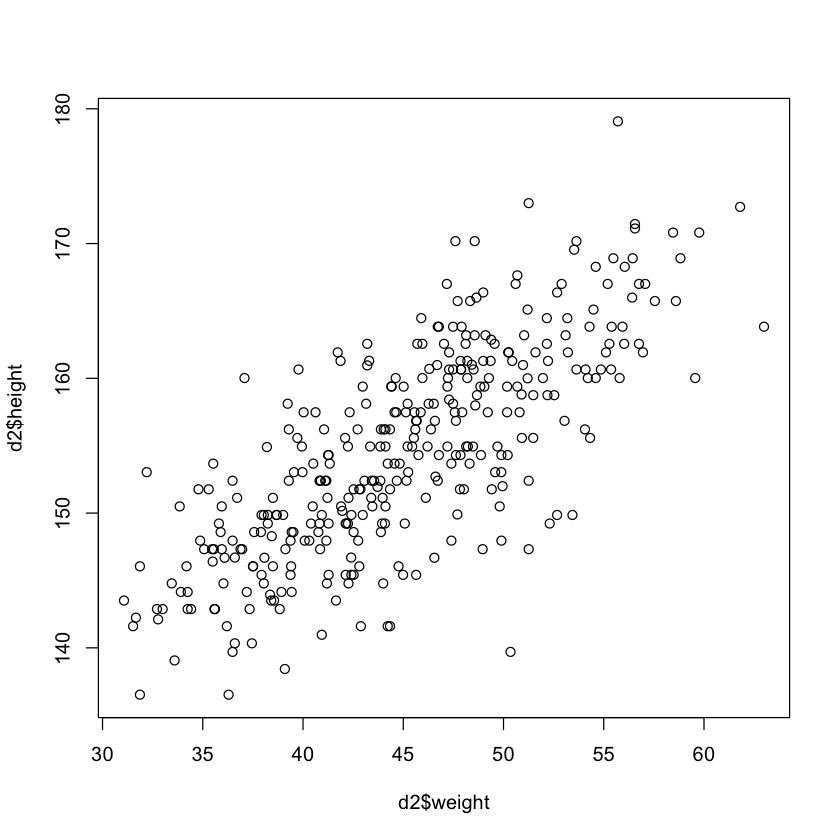

In [128]:
d2 <- d[d$age>=18,]
plot (d2$height~d2$weight)

In [129]:
# sampling and plotting from the prior
m4.3_plot <- function(a, b){
  set.seed(2971)
  N <-100 # 100lines
  plot( 
    NULL,
    xlim=range(d2$weight),
    ylim=c(-100,400), 
    xlab="weight",
    ylab="height")
  abline( h=0,lty=2)
  abline( h=272,lty=1,lwd=0.5)
  mtext( "b~dnorm(0,10)")
  xbar <-mean(d2$weight)
  for (i in 1:N) curve(a[i]+b[i]*(x-xbar),
                    from=min(d2$weight),
                    to=max(d2$weight),
                    add=TRUE,
                    col=col.alpha("black", 0.2))
}

In [130]:
N <- 100

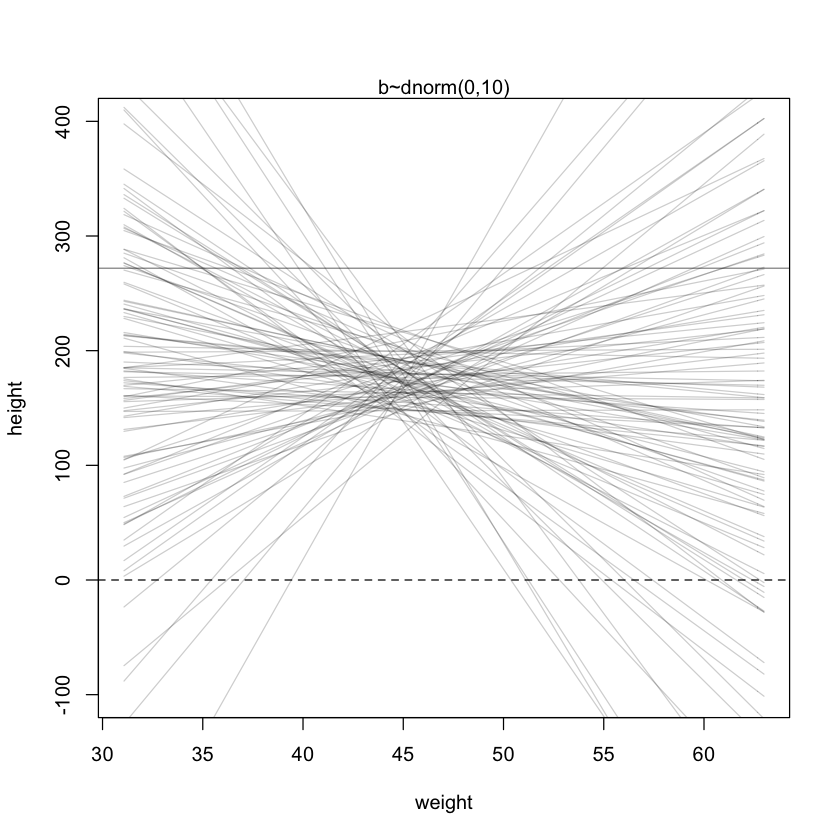

In [131]:
a <-rnorm(N,178,20)
b <-rnorm(N,0,10)
m4.3_plot(a,b)

### correcting the prior for b

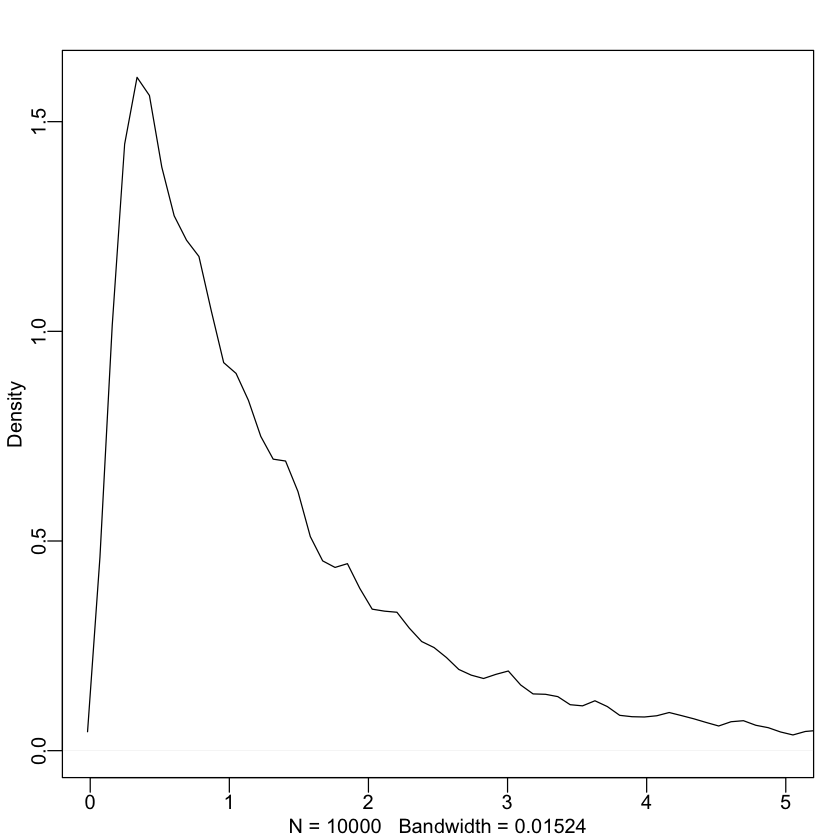

In [132]:
b <-rlnorm(1e4,0,1)
dens(b, xlim=c(0,5), adj=0.1)

lognormal distribution is constrained to positive values

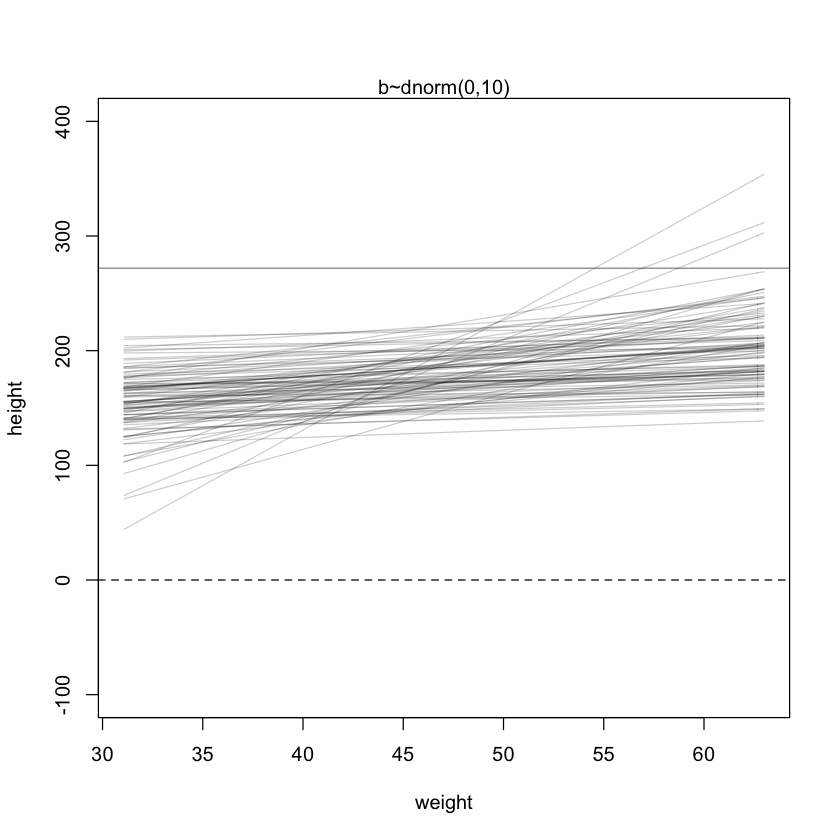

In [133]:
# choosing a different prior for b
b <-rlnorm(N,0,1)
m4.3_plot(a, b)

### finding the posterior

In [134]:
# define the average weight, x-bar

In [135]:
xbar <- mean(d2$weight)

In [136]:
# fit the model
m4.3 <-quap(
  alist(
    height ~ dnorm(mu,sigma),
    mu <- a+b*(weight-xbar),
    a ~ dnorm(178,20),
    b ~ dlnorm(0,1),
    sigma ~ dunif(0,50)
  ) ,data=d2)

In [137]:
precis(m4.3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,154.601388,0.27031303,154.1693756,155.0334005
b,0.903183,0.04192448,0.8361796,0.9701864
sigma,5.071982,0.19116429,4.7664641,5.3774990


In [138]:
round( vcov(m4.3),3)

,a,b,sigma
a,0.073,0.000,0.000
b,0.000,0.002,0.000
sigma,0.000,0.000,0.037


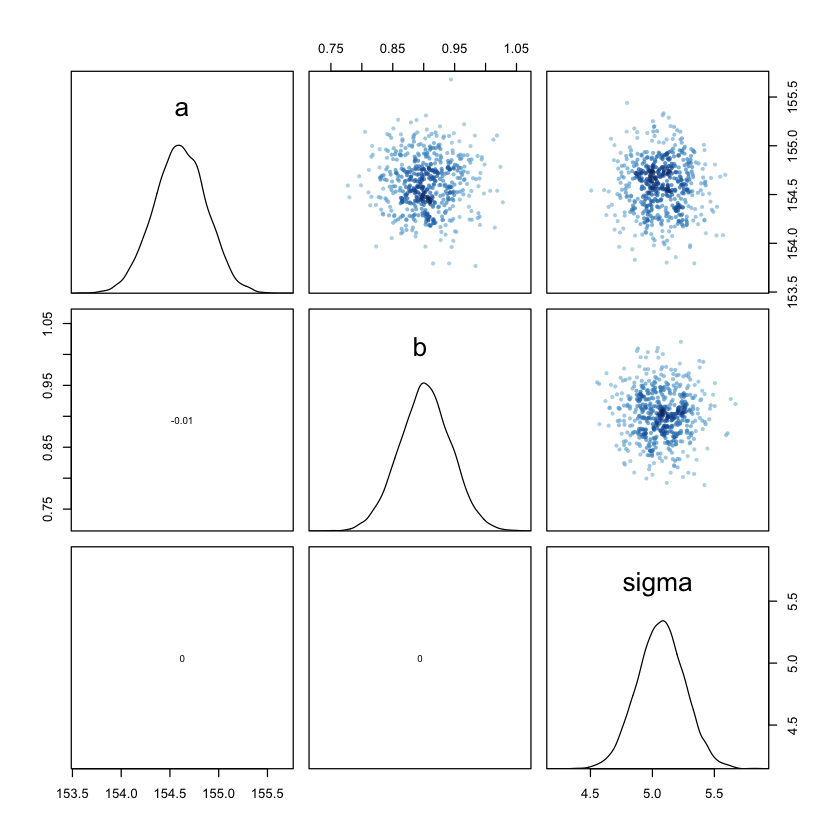

In [139]:
pairs(m4.3)

### sample and plot the posterior mean

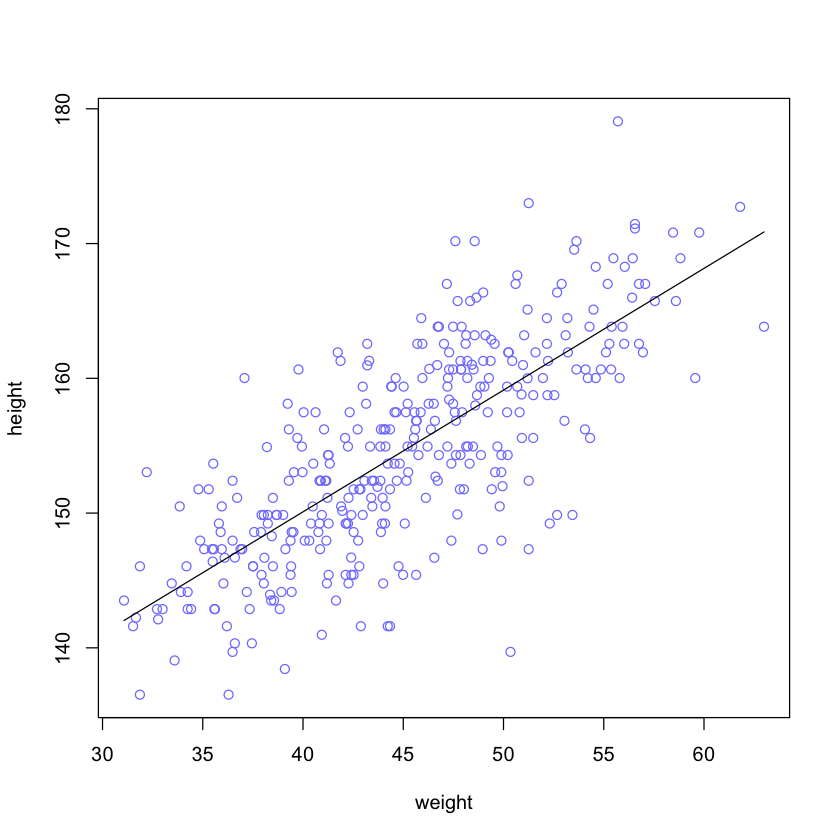

In [140]:
plot(height~weight, data=d2, col=rangi2)
post <-extract.samples(m4.3)
a_map <-mean(post$a)
b_map <-mean(post$b)
curve( a_map+b_map*(x-xbar), add=TRUE)

In [141]:
post <- extract.samples(m4.3)
head(post)

,a,b,sigma
,<dbl>,<dbl>,<dbl>
1,155.1302,0.8800298,5.313264
2,154.9153,0.8237791,5.037168
3,155.0405,0.8737472,5.018233
4,154.4014,0.8690289,5.006380
5,154.6708,0.9431487,5.043334
6,154.5670,0.8940681,4.931981


In [142]:
N <-10
dN <-d2[1:N,]
mN <-quap(
  alist(
    height ~dnorm(mu,sigma),
    mu <-a+b*(weight-mean(weight)),
    a ~dnorm(178,20),
    b ~dlnorm(0,1),
    sigma ~dunif(0,50)
  ) ,data=dN)

In [143]:
# play with the amount of data to show the effect on uncertainty
library(dplyr)
library(rethinking)

In [144]:
m4.3_model <- function(N){
  #set.seed(42)
  dN <-d2[1:N,]
  
  # sampling some data
  #dN <- sample_n(d2, size = N, replace=TRUE)
  
  # fitting the model
  mN <-quap(
    alist(
      height ~dnorm(mu,sigma),
      mu <-a+b*(weight-mean(weight)),
      #mu <- a+b*(weight),
      a ~dnorm(178,20),
      b ~dlnorm(0,1),
      sigma ~dunif(0,50)
    ) ,data=dN)
  
  # extract 20 samples from the posterior
  post <- extract.samples(mN, n=20)
  
  # display raw data and sample size
  plot( dN$weight,dN$height,
        xlim=range(d2$weight) ,ylim=range(d2$height),
        col=rangi2 ,xlab="weight",ylab="height")
  mtext(concat("N =",N))
  # plot the lines, with transparency
  for (i in 1:20)
    curve( post$a[i]+post$b[i]*(x-mean(dN$weight)),
           col=col.alpha("black",0.3) ,add=TRUE)
}

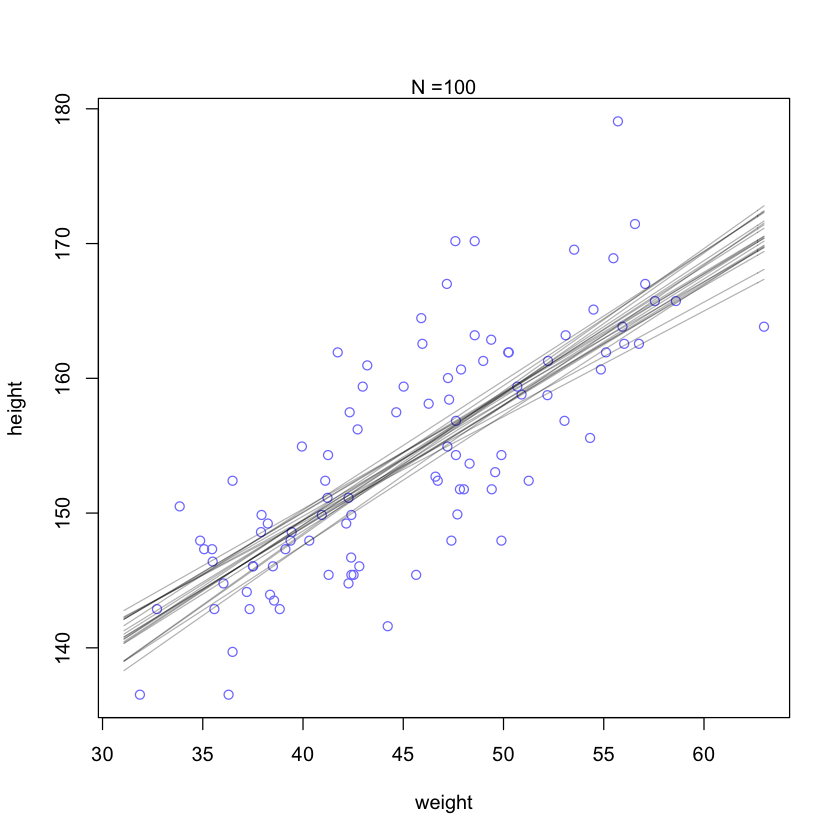

In [145]:
m4.3_model(N=100)

In [146]:
post <- extract.samples(m4.3)

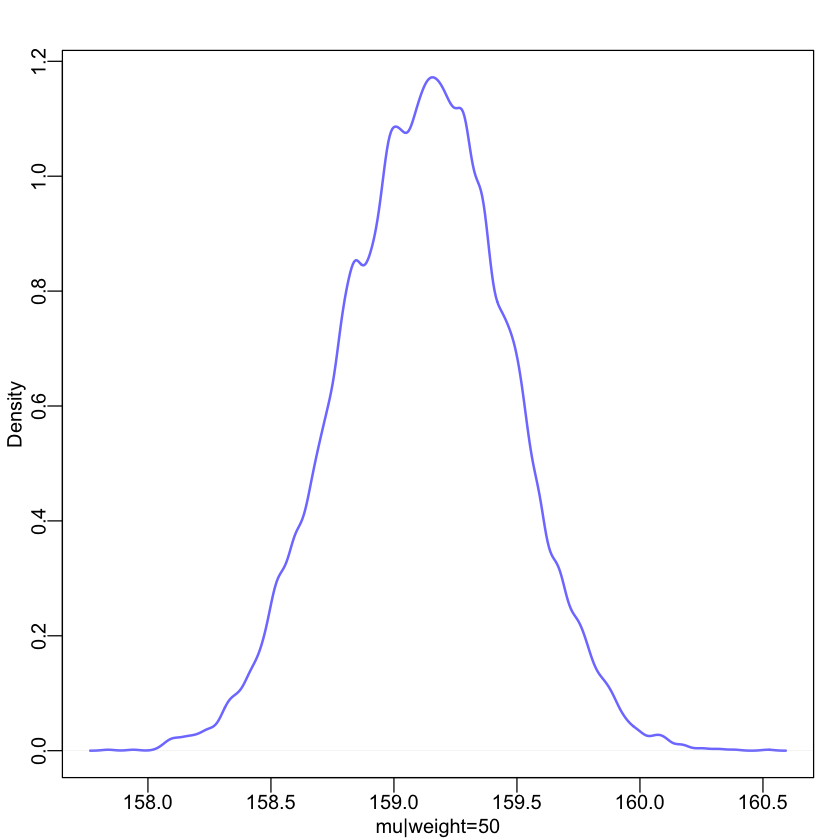

In [147]:
# "predicting" height at a fixed value for weight
mu_at_50 <- post$a+post$b*(50-xbar)
dens( mu_at_50, col=rangi2, lwd=2, xlab="mu|weight=50")

In [148]:
mu <-link(m4.3)
str(mu)

 num [1:1000, 1:352] 157 157 157 158 157 ...


define sequence of weights to compute predictions. these values will be on the horizontal axis

In [149]:
weight.seq <- seq(from=25,to=70,by=1)

use link to compute mu for each sample from posterior and for each weight in weight.seq

In [150]:
mu <- link(m4.3, data=data.frame(weight=weight.seq))
str(mu)

 num [1:1000, 1:46] 136 136 136 138 138 ...


In [151]:
post <- extract.samples(m4.3)

loop over samples and plot each mu value

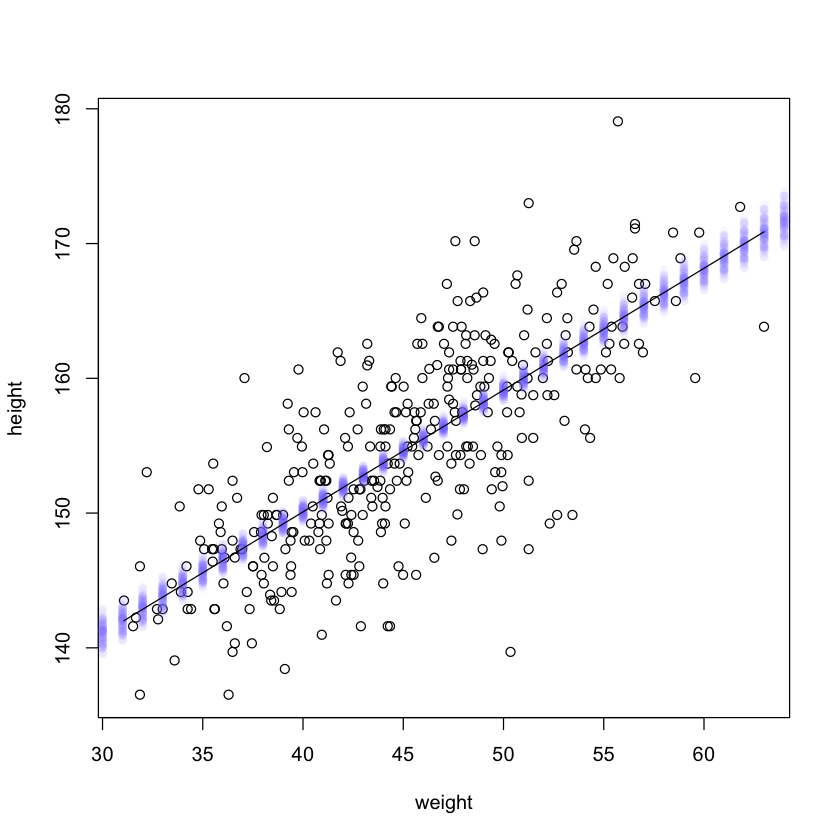

In [152]:
plot( height~weight, d2)
for (i in 1:100)
  points( weight.seq, mu[i,], pch=16,col=col.alpha(rangi2,0.05))
post <-extract.samples(m4.3)
a_map <-mean(post$a)
b_map <-mean(post$b)
curve( a_map+b_map*(x-xbar), add=TRUE)

summarize distribution of each weight value

In [153]:
mu.mean <-apply(mu,2,mean)
mu.PI <-apply(mu,2,PI,prob=0.89)

plot raw data fading out points to make line and interval more visible

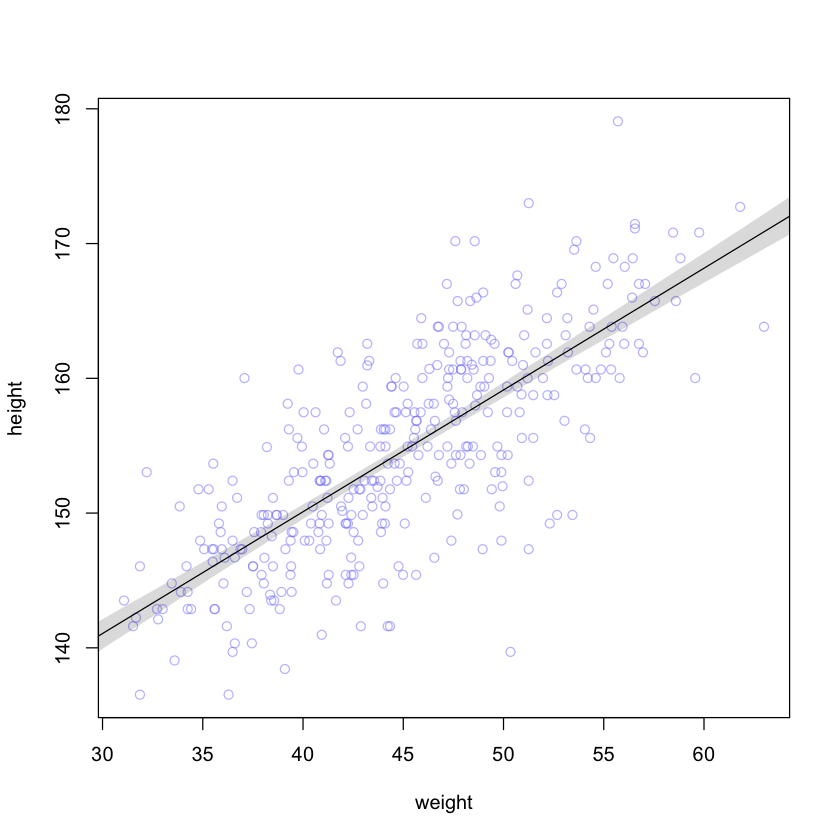

In [154]:
plot(height~weight,data=d2,col=col.alpha(rangi2,0.5))
lines(weight.seq, mu.mean)
shade(mu.PI, weight.seq)

# Prediction Intervals

In [155]:
# simulate posterior observations = simulate 
sim.height <- sim(m4.3, data=list(weight=weight.seq))
str(sim.height)

 num [1:1000, 1:46] 138 132 144 133 138 ...


In [156]:
# 89% posterior prediction interval of observable heights across
# across the values in weight.seq
height.PI <- apply(sim.height, 2, PI, prob=0.5)

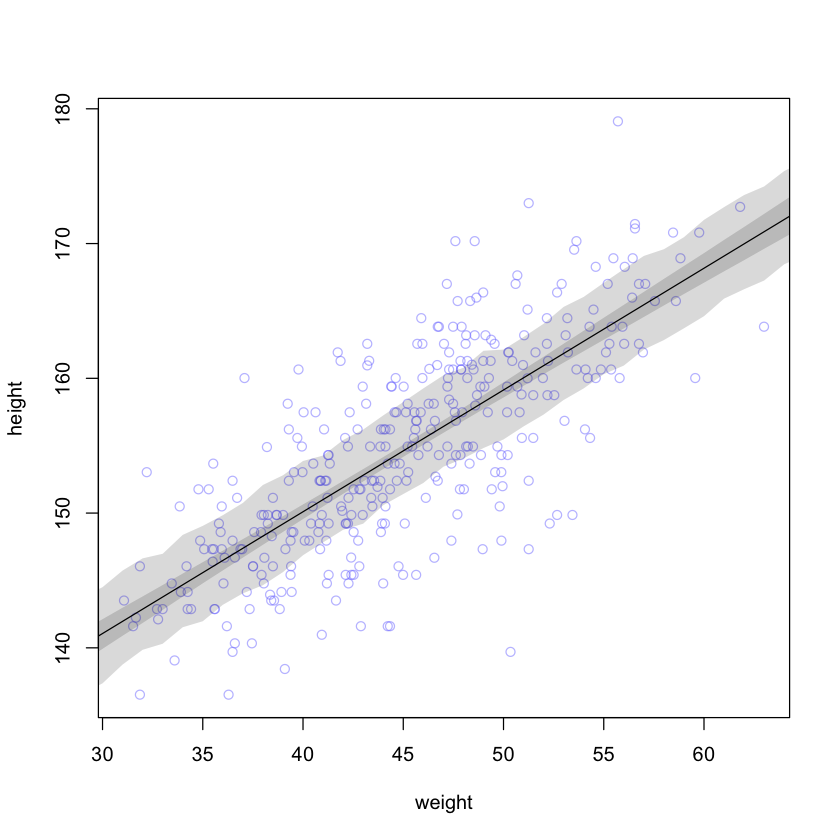

In [157]:
# plot raw data
plot(height ~ weight, d2, col=col.alpha(rangi2, .5))
lines(weight.seq, mu.mean)
# draw HPDI region for line
shade(mu.PI, weight.seq)
# draw PI for simulated heights
shade(height.PI, weight.seq)

In [158]:
# PI for simulated heights: wide shaded region.
# the model expects to find 89% of actual heights in the population in this region

# Compatibility interval: The central 89% of the ways for the model to produce
# the data place the *average X* in this region
# 
# Prediction interval: also incorporates the standard deviation (uncertainty) of height
# 

# Non-linear relationship

In [159]:
# polynomials
data(Howell1)
d <- Howell1

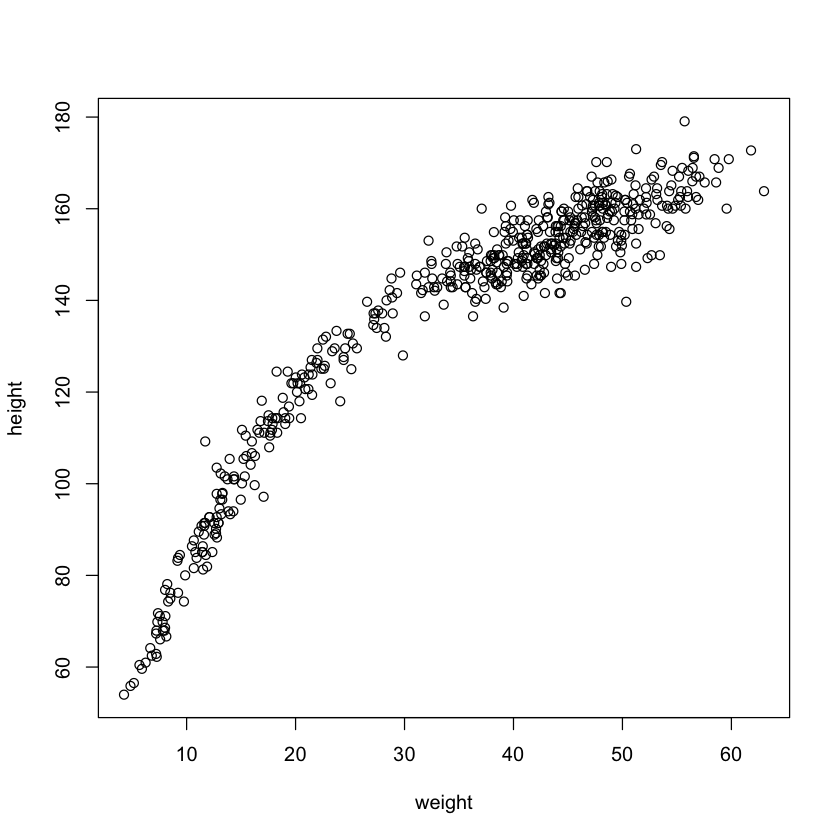

In [160]:
plot(height ~ weight, data=d)

In [161]:
d$weight_s <- (d$weight - mean(d$weight))/sd(d$weight)
d$weight_s2 <- d$weight_s^2
d$weight_s3 <- d$weight_s^3

In [162]:
# fitting the quap
m4.5 <- quap(
  alist(
    height ~ dnorm(mu, sigma),
#    mu <- a + b1*weight_s + b2*weight_s2,
    mu <- a + b1*weight_s + b2*weight_s2 + b3 * weight_s3,
    a ~ dnorm(178, 20),
    b1 ~ dlnorm(0,1), 
    b2 ~ dnorm(0,1),
    b3 ~ dnorm(0,1),
    sigma ~ dunif(0, 50)
  ), data=d)
precis(m4.5)
summary(m4.5)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,146.395150,0.3099887,145.899728,146.890571
b1,15.217402,0.4762683,14.456233,15.978571
b2,-6.202687,0.2571608,-6.613680,-5.791695
b3,3.584120,0.2287762,3.218492,3.949749
sigma,4.829950,0.1469469,4.595100,5.064800


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,146.395150,0.3099887,145.899728,146.890571
b1,15.217402,0.4762683,14.456233,15.978571
b2,-6.202687,0.2571608,-6.613680,-5.791695
b3,3.584120,0.2287762,3.218492,3.949749
sigma,4.829950,0.1469469,4.595100,5.064800


[1] FALSE

null device 
          1

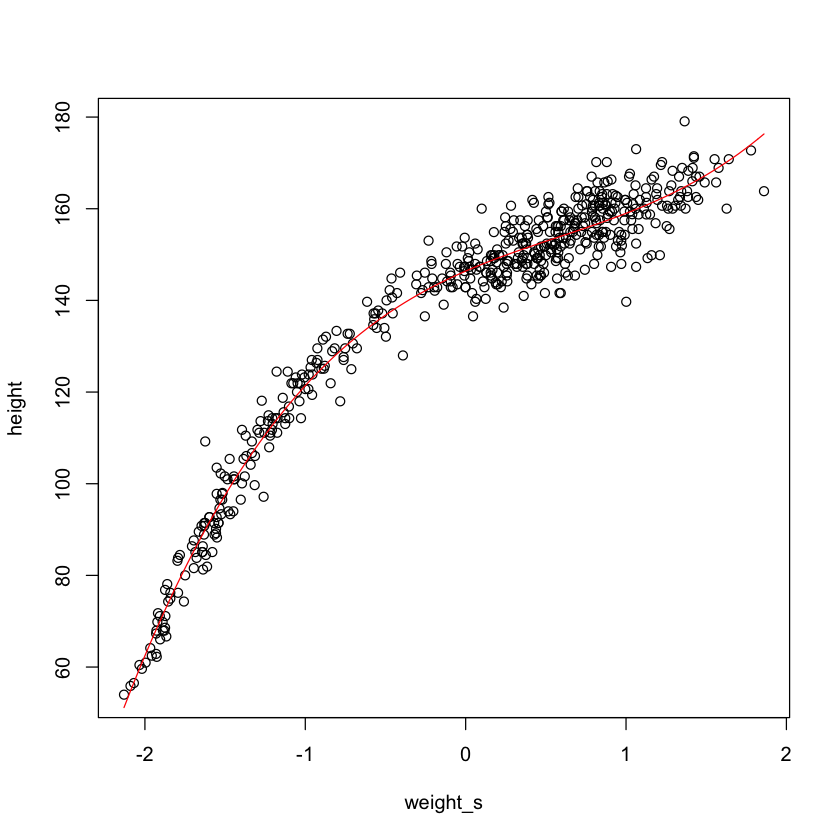

In [163]:
# plotting the mean curves using the estimators
screen()
plot(height ~ weight_s, d)
coef <- m4.5@coef
curve(coef[1]+coef[2]*x+coef[3]*x^2+coef[4]*x^3, add=TRUE, col=col.alpha('red', alpha=1))
dev.off()

In [164]:
# generate a grid of values to create preditions for
weight.seq <- seq(from=-2.2, to=2, length.out=30)
pred_dat <- list(weight_s=weight.seq, weight_s2=weight.seq^2, weight_s3=weight.seq^3)
#pred_dat
#weight.seq

In [165]:
# generate distributions of posterior values for mu
mu <- link(m4.5, data=pred_dat)
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI, prob=0.89)

In [166]:
# simulate posterior observations (considers uncertainty stemming from sigma)
sim.height <- sim(m4.5, data=pred_dat)
height.PI <- apply(sim.height, 2, PI, prob=0.89)

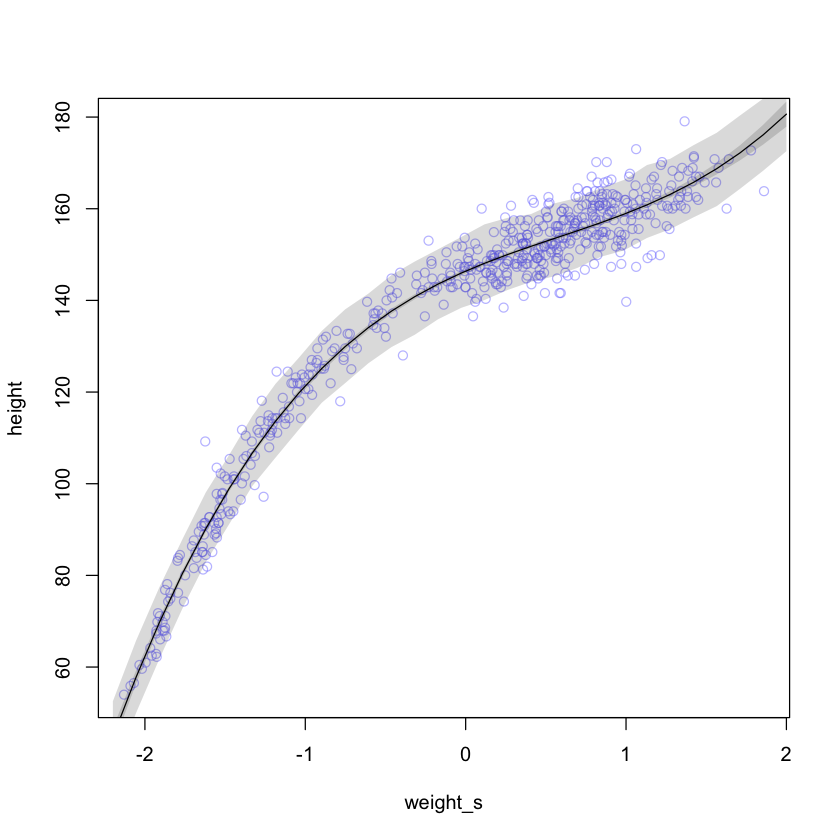

In [167]:
# plot this
plot(height ~ weight_s, d, col=col.alpha(rangi2, .5))
lines(weight.seq, mu.mean)
shade(mu.PI, weight.seq)
shade(height.PI, weight.seq)

## Splines

In [168]:
data("cherry_blossoms")
d <- cherry_blossoms
precis(d, hist=F)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
year,1408.000000,350.8845964,867.77000,1948.23000
doy,104.540508,6.4070362,94.43000,115.00000
temp,6.141886,0.6636479,5.15000,7.29470
temp_upper,7.185151,0.9929206,5.89765,8.90235
temp_lower,5.098941,0.8503496,3.78765,6.37000


In [162]:
plot(doy~year, data=d)

pdf 
  2